# Prediction of "Sachkonto" - from a few Columns based on Trainingsdata from SAP BSAK

### Possible improvements
7. Unbalanced data-set: find some strategy to counter this
8. use CATBOOST instead of XGBoost - just for comparison
9. Optimization of model with "AutoML" / (Bayesian) Parameter-Search of some sort (possibly better than grid-search )
10. Consider to use Scikit columnTransformer and pipeline instead of doing everything manually: this would make the entire pipeline testable.
11. Split data preparation into separate notebook


# Imports

In [1]:
import pandas as pd
import numpy as np
from utils_bsak import printSamplesFromSaktos
from utils_bsak import is_date_column, is_decimal_column, convert_column_decimal2float

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from utils_bsak import target_min_value_records

import joblib

import xgboost as xgb


# Load Preprosessed Data & Encoders

#### Files for Reading Preprocessed Data and Writting Onnx-Model

In [2]:
# filenames for ONNX model

onnx_model_name = "Sachkonto_stratified" # name of the exportet ONNX-model that is going to be generated
path_model= "../models/model_" + onnx_model_name + ".onnx"
#path_model= "models/"

# files with preprocessed data

folder_preprocessed_data = "../data_preprocessed/"
file_joblib_data = 'Data_' + onnx_model_name + '.pkl'
path_joblib_data = folder_preprocessed_data + file_joblib_data # path for dumping preprocessed data



file_joblib_onnx_params = 'OnnxParams_' + onnx_model_name + '.pkl'
path_joblib_onnx_params = folder_preprocessed_data + file_joblib_onnx_params

### Load Data

In [3]:
# Code-Snippet: Load Preprosessed Data & Encoders
data = joblib.load(path_joblib_data)

X_train = data["X_train"]
X_test = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]
column_encoders = data["column_encoders"]
target_dict = data["target_dict"]
Steuerkennzeichen_dict = data["Steuerkennzeichen_dict"]

In [4]:
target_dict.values()

dict_values([33000000, 34000000, 34050000, 34100000, 35000000, 36500000, 36500001, 36500120, 38800000])

## Use Boruta to find the most relevant features in the dataset

In [5]:
#Use Boruta after the split to avoid data leakage

# for notebook control:
apply_Boruta = False
#apply_Boruta = True

if(apply_Boruta):

    from boruta import BorutaPy
    from sklearn.ensemble import RandomForestClassifier

    # Define the Random Forest model
    rf_model = xgb.XGBClassifier(n_jobs=-1, verbosity=0)

    boruta_selector = BorutaPy(rf_model, n_estimators='auto', random_state=42)
    boruta_selector.fit(X_train.values, y_train)

    # Check the results
    selected_features = X_train.columns[boruta_selector.support_].tolist()
    print("--------------------------------")
    print("Selected Features:", selected_features)

    # Optional: Features that were rejected
    rejected_features = X_train.columns[~boruta_selector.support_].tolist()
    print("Rejected Features:", rejected_features)
    print("--------------------------------")

### All datasets combined Boruta selected_features (runtime: 21m 40s):
Selected Features: ['Buchungskreis', 'Lieferant', 'Position', 'WÃ¤hrung', 'Belegart', 'Buchungsperiode', 'Steuerkennzeichen', 'Betrag', 'Funktionale WÃ¤hrung', 'Zahlungsbedingung', 'Tage 1', 'Skontoprozentsatz 1', 'Skontobasis', 'Skontobetrag', 'Skontobetrag.1', 'Zahlweg', 'Zahlungssperre', 'Hausbank', 'Partnerbanktyp', 'Steuerkennzeichen.1', 'Steuerkennzeichen.2', 'HW-2-Betrag', 'Skontobetrag HW2', 'ReferenzschlÃ¼ssel 2', 'WÃ¤hrung Hauptbuch', 'Betrag Hauptbuch', 'Profitcenter', 'Position im Sender System', 'Währung', 'Funktionale Währung', 'Währung Hauptbuch']

# Train XGBoost Model

## Define a factory-function for the model

In [6]:
# define a factory-function for the model - to always work with the same type of model (... could be implemented as singleton...)
def create_Model():
    return xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

## Define Selected Features

Using the results from the Boruta-analysis - define different sets of columns to train on. <br>
Since this is a demonstrator I tried to use different features to prove flexibility. <br>
Which columns to use is dependent on the front-end application in which the model is going to be used. <br>

In [7]:

from sklearn.model_selection import train_test_split

# Using the results from the Boruta-analysis - define different sets of columns to train on.
# Since this is a demonstrator I tried to use different features to prove flexibility.
# Which columns to use is dependent on the front-end application in which the model is going to be used.

# all combined:
#all_combined =  ['Buchungskreis', 'Lieferant', 'Position'] # Accuracy (in %): 96.62 +/- 2.62 --- "Position" is weird - how can this be relevant?!
all_combined =  ['Buchungskreis', 'Lieferant', 'Steuerkennzeichen']


## Train on Selected Features

### Conversion of the column names for later ONNX-conversion of the model:

In [8]:
# chose one of the feature selections:
final_seleced_features =  all_combined

X_train = X_train[final_seleced_features]
X_test = X_test[final_seleced_features]

X_train_old = { f"f{i}" : col for i, col in enumerate(X_train.columns)}
X_train.columns = [ f"f{i}" for i in range(X_train.shape[1])]
X_test_old = { f"f{i}" : col for i, col in enumerate(X_test.columns)}
X_test.columns = [ f"f{i}" for i in range(X_test.shape[1])]

In [9]:


# conversion of the column

print("--------------------------------")
print(f"Features the model is trained on: {final_seleced_features}")
print("--------------------------------")
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape : {X_test.shape}")
print("--------------------------------")
print(f"X_train.head(3):{X_train.head(3)}")
print(f"X_test.head(3) : {X_test.head(3)}")
print("--------------------------------")

model = create_Model()
model.fit(X_train, y_train)


--------------------------------
Features the model is trained on: ['Buchungskreis', 'Lieferant', 'Steuerkennzeichen']
--------------------------------
X_train.shape: (93996, 3)
X_test.shape : (23499, 3)
--------------------------------
X_train.head(3):         f0         f1  f2
18904  1000  100460947  52
14499  1000  100374650  52
97042  1101  270000145  52
X_test.head(3) :          f0         f1  f2
64197  1000  100457786  52
81168  1000  101734793  52
46936  1000  100231607  52
--------------------------------


c:\Users\Hal9\anaconda3\envs\CondaSapBSAKEnv\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

# Model Quality Assessment

## Simple Run Accuracy

In [10]:
# make predictions for test data
print("--------------------------------")
print(f"We have {y_test.shape[0]} rows of test-data.")
print("--------------------------------")

y_pred = model.predict(X_test)
""" 
print("--------------------------------")
print(y_pred[:10])
print("--------------------------------")
#predictions = [round(value) for value in y_pred] """

# evaluate predictions
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
#accuracy = accuracy_score(y_test, predictions)
print("--------------------------------")
print("Simple One-Run Accuracy: %.2f%%" % (accuracy * 100.0))
print("--------------------------------")

--------------------------------
We have 23499 rows of test-data.
--------------------------------
--------------------------------
Simple One-Run Accuracy: 99.56%
--------------------------------


## Check Scikits classification_report:

In [11]:
from sklearn.metrics import classification_report

# Evaluate the model with precision, recall, and F1-score
# print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_label_encoder.classes_.astype(str)))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=list(map(str,target_dict.values()))))
print("--------------------------------")


Classification Report:
               precision    recall  f1-score   support

    33000000       1.00      1.00      1.00     18680
    34000000       0.97      0.94      0.95       186
    34050000       1.00      0.96      0.98      2162
    34100000       1.00      1.00      1.00        17
    35000000       1.00      1.00      1.00       460
    36500000       0.95      1.00      0.98      1828
    36500001       1.00      1.00      1.00         6
    36500120       1.00      1.00      1.00        21
    38800000       1.00      1.00      1.00       139

    accuracy                           1.00     23499
   macro avg       0.99      0.99      0.99     23499
weighted avg       1.00      1.00      1.00     23499

--------------------------------


## Accuracy with Cross-Validation

In [12]:
import warnings

warnings.simplefilter('ignore', UserWarning)

from sklearn.model_selection import cross_val_score, KFold

X = pd.concat([X_train, X_test], ignore_index=True, axis=0)
y = np.append(y_train, y_test, axis=0)

print("----------- Check encoding ---------------------")
print(y[:10])
print("--------------------------------")

results = cross_val_score(model, X, y, cv=5)
print("--------------------------------")
print(f"Accuracy (in %): {results.mean() * 100:.2f} +/- {results.std() * 100:.2f}")
print("--------------------------------")

----------- Check encoding ---------------------
[0 0 2 0 0 0 0 0 0 0]
--------------------------------
--------------------------------
Accuracy (in %): 99.55 +/- 0.04
--------------------------------


## Confusion Matrices

### Straight Confusion Matrix

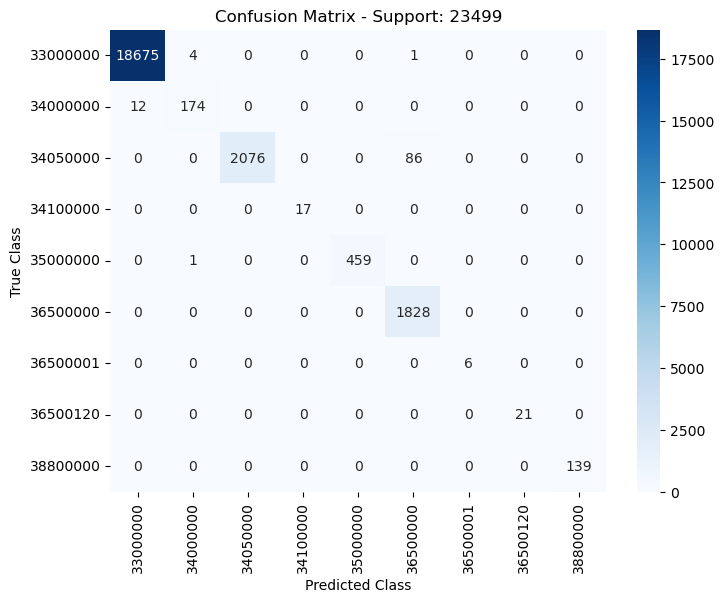

In [13]:
from utils_bsak import plot_confusion_matrix

y_pred = model.predict(X_test)

plot_confusion_matrix(y_test=y_test, y_pred=y_pred, labels=list(map(str, target_dict.values())))

### Top-k Confusion Matrix

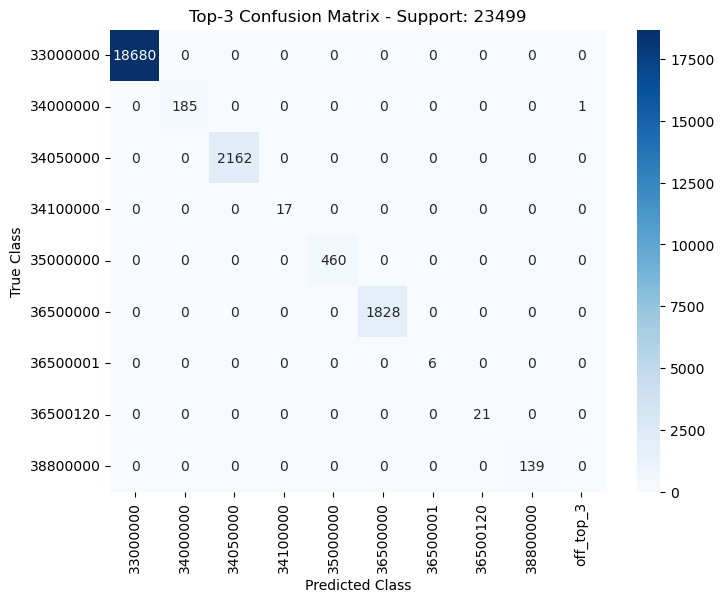

In [14]:
from utils_bsak import plot_top_k_confusion_matrix

k = 3
y_pred_prob = model.predict_proba(X_test)
plot_top_k_confusion_matrix(y_test=y_test, y_pred_prob=y_pred_prob, labels=list(map(str, target_dict.values())), top_k=k, show_off_top_k_info=True)

# Export/ Convert Model to ONNX

## Model Conversion and Saving

In [15]:
import xgboost as xgb
from onnxmltools import convert_xgboost
from onnxmltools.convert.common.data_types import FloatTensorType

# rename the columns of X to make Onnx conversion possible:
#X_old_columns = { f"f{i}" : col for i, col in enumerate(X_train.columns)}
#X_train.columns = [f"f{i}" for i in range(X_train.shape[1])]

# create a dense-matrix, DMatrixx, and set enable_categorical=True:
dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(data=X_test, label=y_test, enable_categorical=True)

# Convert the model to ONNX format
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_xgboost(model, initial_types=initial_type, target_opset=13)

# Save the ONNX model to a file in D:\1000_DataScience_MachineLearning\1000_ML_Projects\1000_Github_ML_2\projects_planned\Psinova_Examples\saktoBsik_private :

with open(path_model, "wb") as f:
    f.write(onnx_model.SerializeToString())

print("------------------------------------------------------------------------")
print(f"model name: {onnx_model_name}")
print("------------------------------------------------------------------------")



------------------------------------------------------------------------
model name: Sachkonto_stratified
------------------------------------------------------------------------


In [20]:
import onnx
from onnx import checker

try:
    model = onnx.load(path_model)
    checker.check_model(model)
except Exception as ex:
    print("ONNX model not saved correctly or faulty")
    print(ex)
else: 
    print("ONNX model is valid and saved succesfully")

ONNX model is valid and saved succesfully


## Write ONNX-Model Parameter

In [16]:
import joblib, onnxmltools, xgboost

onnx_parameters = {
    "onnx_model_name" : onnx_model_name,
    "trained_features" : final_seleced_features,
    "xgboost_version" : xgboost.__version__,
    "onnxmltools_version" : onnxmltools.__version__,
}

joblib.dump(onnx_parameters, path_joblib_onnx_params)

['../data_preprocessed/OnnxParams_Sachkonto_stratified.pkl']

In [17]:
import xgboost
print(xgboost.__version__)

#Answer:
# 1.4.2

1.7.6


In [18]:
import onnxmltools
print(onnxmltools.__version__)

# Answer:
# 1.7.0

1.11.1


Working combination of versions of xgboost and onnxmltools:

xgboost : 1.4.2 <br>
onnxmltools : 1.7.0

# TO DO : 
+ explain Classification Report
+ deal with imbalance

#### Note: Strategies to Address Imbalance 

+ Cost-Sensitive Learning: Assign higher misclassification costs to the minority class, encouraging the model to consider it more seriously.
+ Alternative Splitting Criteria: Use metrics like Hellinger distance (what is this?) instead of traditional ones like information gain, as it better handles skewed distributions (why? How?).
+ Sampling Techniques: Balance the dataset by oversampling the minority class or undersampling the majority class, or by using wrapper frameworks that combine sampling with the splitting metric.
+ Adjusted Evaluation Metrics: Accuracy alone is misleading in imbalanced settings. Instead, prioritize metrics like precision, recall, and F1-score to assess the model’s performance on the minority class more accurately.